### Natural Language Processing with GloVe & LSTM
Twitter Outrage Machine (OM); Insight Project- Michele Waters

* It has been observed in popular culture that a large "Twitter ratio" (a ratio of Twitter comments/likes >1) is usually indicative that other Twitter users strongly disagree with a Twitter post. 



* Hypothesis: the "Twitter ratio" can be used as a metric of Twitter outrage/ significant negative sentiment, 



* Let's use the tweet text data we collected ('1_Scrape_Tweets_Tweepy.py'), cleaned ('2_Clean_CSV_to_SQL.py' & '4_Clean_Text_Label_Categories_Merge_Tables_Data_Manipulation.ipynb'), and scoped down & explored ('5_EDA_Clustering.ipynb') in combination with the user account infomation we collected ('3_Get_Twitter_User_Data_Twython_no_key.py') from 100+ Twitter accounts across governement, news, entertainment/sports, and industry to see if we can predict whether a tweet will be ratioed.



* Goals:


* Use GloVE word embeddings with LSTM to predict Twitter ratios

In [1]:
import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
conn=sqlite3.connect('merged_tweets_2019_2020.db')
cursor= conn.cursor()

In [3]:
#Create function to query SQL data
def query_data(sql_statement):
    df=pd.read_sql(sql_statement, conn)
    #cursor.execute(sql_statement)
    return df.to_dict('records')

In [4]:
#Connect to database file with merged user account info/cleaned tweets and scoped data
df=pd.DataFrame(query_data('SELECT * FROM merged_twitter_data_gated'))

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 249716 entries, 0 to 249715
Data columns (total 52 columns):
account_id                 249716 non-null int64
author_id                  249716 non-null int64
category                   249716 non-null object
cleaned_text               249716 non-null object
cluster_labels             249716 non-null int64
created_at                 249716 non-null object
d_log_ratio                249716 non-null int64
d_richter_like_ratio       249716 non-null float64
d_richter_retweet_ratio    249716 non-null float64
date                       249716 non-null object
description                249716 non-null object
doy                        249716 non-null int64
encoded_hashtag            249716 non-null int64
encoded_urls               249716 non-null int64
favorites                  249716 non-null int64
favourites_count           249716 non-null int64
followers_count            249716 non-null int64
formatted_date             249716 non-null obje

In [6]:
df.describe()

,account_id,author_id,cluster_labels,d_log_ratio,d_richter_like_ratio,d_richter_retweet_ratio,doy,encoded_hashtag,encoded_urls,favorites,...,ratio_richter_retweets,ratio_target,reply_count,retweets,second,statuses_count,tweet_id,url_present,verified,year
count,2.497160e+05,2.497160e+05,249716.000000,249716.000000,249716.000000,249716.000000,249716.000000,249716.000000,249716.000000,249716.000000,...,249716.000000,249716.000000,249716.000000,249716.00000,249716.000000,249716.000000,2.497160e+05,249716.000000,249716.0,249716.000000
mean,2.362037e+16,2.362037e+16,1.225636,-2.091212,-4.152750,-1.099673,150.134329,1043.532701,19616.216494,9013.625967,...,-1.099598,0.011409,792.001358,1595.72681,27.051691,94096.199991,1.179439e+18,0.530755,1.0,2019.342489
std,1.462309e+17,1.462309e+17,0.987176,1.309782,3.189864,2.467334,103.661830,1998.970012,23874.778772,33047.102923,...,2.450426,0.106202,3895.835319,6038.51713,18.214983,88705.737514,5.600362e+16,0.499054,0.0,0.474543
min,7.832140e+05,7.832140e+05,0.000000,-11.000000,-20.000000,-15.000000,1.000000,0.000000,0.000000,1.000000,...,-14.702400,0.000000,1.000000,1.00000,0.000000,19.000000,1.079891e+18,0.000000,1.0,2019.000000
25%,1.612992e+07,1.612992e+07,1.000000,-3.000000,-6.000000,-3.000000,65.000000,0.000000,0.000000,144.000000,...,-2.580217,0.000000,12.000000,26.00000,11.000000,16391.000000,1.129204e+18,0.000000,1.0,2019.000000
50%,1.992314e+07,1.992314e+07,1.000000,-2.000000,-4.000000,-1.000000,126.000000,0.000000,3691.500000,623.000000,...,-1.171555,0.000000,45.000000,108.00000,27.000000,52359.000000,1.183775e+18,1.000000,1.0,2019.000000
75%,1.195095e+08,1.195095e+08,2.000000,-1.000000,-2.000000,0.000000,237.000000,1191.250000,45725.000000,2924.000000,...,0.184938,0.000000,219.000000,506.00000,43.000000,142847.000000,1.229444e+18,1.000000,1.0,2020.000000
max,1.200452e+18,1.200452e+18,3.000000,4.000000,14.000000,20.000000,365.000000,7653.000000,63428.000000,894346.000000,...,19.652965,1.000000,193489.000000,298373.00000,59.000000,418834.000000,1.271117e+18,1.000000,1.0,2020.000000


In [7]:
df.head()

,account_id,author_id,category,cleaned_text,cluster_labels,created_at,d_log_ratio,d_richter_like_ratio,d_richter_retweet_ratio,date,...,text,text_processed,to,tweet_id,url,url_attached,url_present,username,verified,year
0,813286,813286,1,true key moment history going depend young peo...,2,Mon Mar 05 22:08:25 +0000 2007,-3,-13.0,-6.0,2020-06-07 23:25:01+00:00,...,As has always been true at key moments in hist...,as has always been true at key moments in his...,None,1269772382509596677,https://t.co/93Y27HEnnX,https://www.obama.org/updates/president-obama-...,1,barackobama,1,2020
1,813286,813286,1,seen power voice speak injustice know toll tak...,2,Mon Mar 05 22:08:25 +0000 2007,-3,-12.0,-6.0,2020-06-06 00:37:08+00:00,...,We’ve seen the power that our voices have when...,we have seen the power that our voices have w...,ObamaFoundation,1269065755179524096,https://t.co/93Y27HEnnX,https://twitter.com/ObamaFoundation/status/126...,1,barackobama,1,2020
2,813286,813286,1,national gun violence awareness day wearorange...,2,Mon Mar 05 22:08:25 +0000 2007,-2,-12.0,-4.0,2020-06-05 16:21:00+00:00,...,"On National Gun Violence Awareness Day, we #We...",on national gun violence awareness day we w...,None,1268940899616243715,https://t.co/93Y27HEnnX,None,0,barackobama,1,2020
3,813286,813286,1,city country mbk alliance community city count...,2,Mon Mar 05 22:08:25 +0000 2007,-3,-11.0,-6.0,2020-06-04 23:15:58+00:00,...,"Third, every city in this country should be a ...",third every city in this country should be a...,None,1268682939799425024,https://t.co/93Y27HEnnX,http://obama.org/mbka/about-mbk-communities,1,barackobama,1,2020
4,813286,813286,1,second mayor review use force policy member co...,2,Mon Mar 05 22:08:25 +0000 2007,-3,-12.0,-6.0,2020-06-04 23:15:58+00:00,...,"Second, every mayor should review their use of...",second every mayor should review their use o...,None,1268682938251710464,https://t.co/93Y27HEnnX,http://obama.org/mayor-pledge,1,barackobama,1,2020


In [8]:
df.columns

Index(['account_id', 'author_id', 'category', 'cleaned_text', 'cluster_labels',
       'created_at', 'd_log_ratio', 'd_richter_like_ratio',
       'd_richter_retweet_ratio', 'date', 'description', 'doy',
       'encoded_hashtag', 'encoded_urls', 'favorites', 'favourites_count',
       'followers_count', 'formatted_date', 'friends_count', 'got_ratioed',
       'got_richter_ratioed', 'hashtag_present', 'hashtags', 'hour', 'id',
       'link_to_tweet', 'listed_count', 'location', 'log_ratio', 'minute',
       'name', 'num_hashtags', 'ratio_comment_like', 'ratio_comment_retweet',
       'ratio_richter_likes', 'ratio_richter_retweets', 'ratio_target',
       'reply_count', 'reply_to', 'retweets', 'second', 'statuses_count',
       'text', 'text_processed', 'to', 'tweet_id', 'url', 'url_attached',
       'url_present', 'username', 'verified', 'year'],
      dtype='object')

In [9]:
#Numeric columns
df.select_dtypes('number').columns

Index(['account_id', 'author_id', 'cluster_labels', 'd_log_ratio',
       'd_richter_like_ratio', 'd_richter_retweet_ratio', 'doy',
       'encoded_hashtag', 'encoded_urls', 'favorites', 'favourites_count',
       'followers_count', 'friends_count', 'got_ratioed',
       'got_richter_ratioed', 'hashtag_present', 'hour', 'id', 'listed_count',
       'log_ratio', 'minute', 'num_hashtags', 'ratio_comment_like',
       'ratio_comment_retweet', 'ratio_richter_likes',
       'ratio_richter_retweets', 'ratio_target', 'reply_count', 'retweets',
       'second', 'statuses_count', 'tweet_id', 'url_present', 'verified',
       'year'],
      dtype='object')

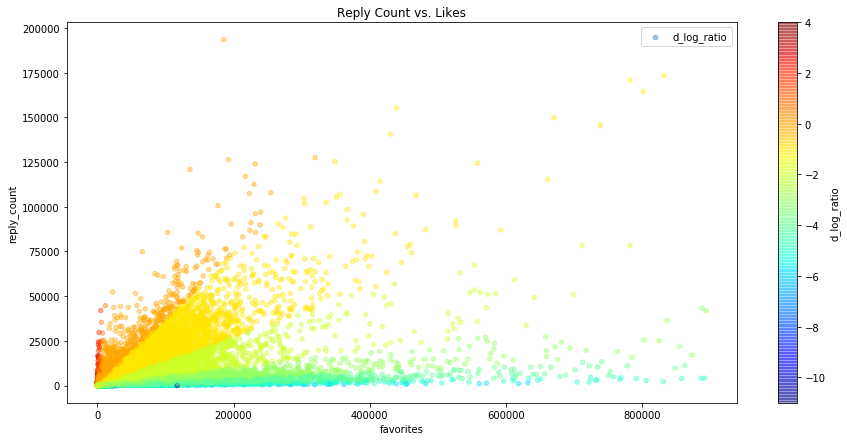

In [10]:
#Look at discrete values for log ratio score using matplotlib
fig, ax = plt.subplots()
df.plot(kind="scatter", x="favorites", y="reply_count", alpha=0.4,
            label='d_log_ratio',
            c='d_log_ratio', cmap=plt.get_cmap("jet"), colorbar=True,
            figsize=(15,7), title='Reply Count vs. Likes', ax=ax)
plt.legend()
plt.show()

In [11]:
#df.doy

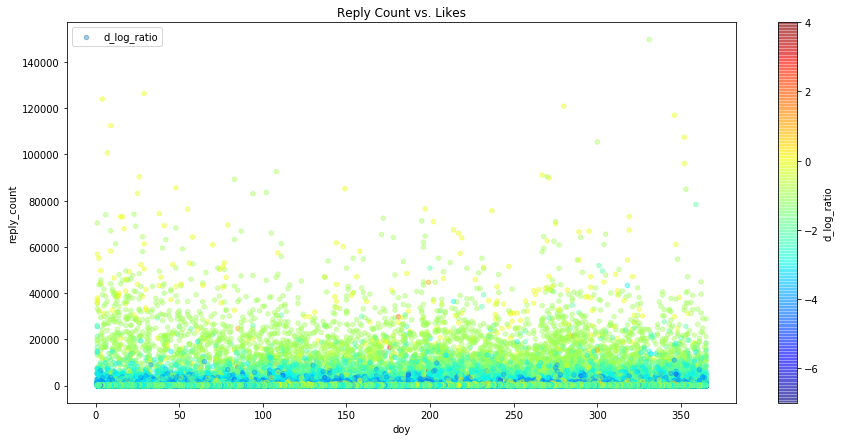

In [12]:
#Look at discrete values for log ratio score using matplotlib
fig, ax = plt.subplots()
df[df.year==2019].plot(kind="scatter", x="doy", y="reply_count", alpha=0.4,
            label='d_log_ratio',
            c='d_log_ratio', cmap=plt.get_cmap("jet"), colorbar=True,
            figsize=(15,7), title='Reply Count vs. Likes', ax=ax)
plt.legend()
plt.show()

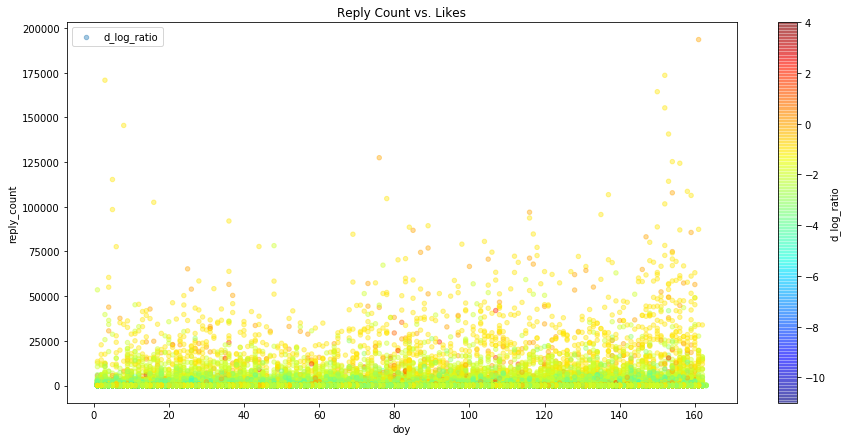

In [13]:
#Look at discrete values for log ratio score using matplotlib
fig, ax = plt.subplots()
df[df.year==2020].plot(kind="scatter", x="doy", y="reply_count", alpha=0.4,
            label='d_log_ratio',
            c='d_log_ratio', cmap=plt.get_cmap("jet"), colorbar=True,
            figsize=(15,7), title='Reply Count vs. Likes', ax=ax)
plt.legend()
plt.show()

In [14]:
df['date_num']=df.doy

In [15]:
df['date_num'].max()

365

In [16]:
date_num20=df.loc[df[df.year==2020].index].date_num+365 #= df[df.year==2020].date_num+365

In [17]:
date_num20[0]

524

In [18]:
df.date_num[df[df.year==2020].index]=date_num20

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [19]:
df.category=df.category.astype('int64')

In [20]:
#Select features for clustering; cluster labels was calculated in Jupyter Notebook 5 (EDA file)
selected_features=['cleaned_text', 'followers_count','friends_count', 'listed_count', 'favourites_count', 'statuses_count',
                   'doy','date_num', 'hour', 'minute', 'second', 'encoded_urls',
                   'url_present', 'encoded_hashtag', 'hashtag_present', 'num_hashtags', 'category', 'ratio_target']

In [21]:
#Selected features
selected_df=df[selected_features]

In [22]:
selected_df.head()

,cleaned_text,followers_count,friends_count,listed_count,favourites_count,statuses_count,doy,date_num,hour,minute,second,encoded_urls,url_present,encoded_hashtag,hashtag_present,num_hashtags,category,ratio_target
0,true key moment history going depend young peo...,119658056,604838,220889,5,15843,159,524,23,25,1,60582,1,0,0,0,1,0
1,seen power voice speak injustice know toll tak...,119658056,604838,220889,5,15843,158,523,0,37,8,49129,1,0,0,0,1,0
2,national gun violence awareness day wearorange...,119658056,604838,220889,5,15843,157,522,16,21,0,0,0,7251,1,1,1,0
3,city country mbk alliance community city count...,119658056,604838,220889,5,15843,156,521,23,15,58,14350,1,0,0,0,1,0
4,second mayor review use force policy member co...,119658056,604838,220889,5,15843,156,521,23,15,58,14349,1,0,0,0,1,0


In [23]:
#Original tweet
df['text'][0]

'As has always been true at key moments in history, it’s going to depend on young people to go out there and rewrite what is possible. I couldn’t be prouder of all the young people leading that change right now. Here’s my advice for the Class of 2020:'

In [24]:
#Cleaned tweet
selected_df['cleaned_text'][0]

'true key moment history going depend young people rewrite possible prouder young people leading change right advice class'

In [25]:
#double check there are no NaN values
selected_df['cleaned_text'].isna().sum()

0

In [26]:
#Check for missing values
df.cleaned_text.isna().sum()

0

Despite there being no NaN values in the text data, I still discovered some missing text data that needed to be removed. Let's get the indices of these missing values:

In [27]:
#All data: 249716 rows × 1 columns
#Missing values: 12783 rows × 1 columns 
df[['cleaned_text']][df['cleaned_text']==''].index

Int64Index([   103,    276,    286,    340,    459,    515,    695,    743,
               839,   1200,
            ...
            248905, 248931, 249013, 249032, 249054, 249186, 249233, 249266,
            249299, 249644],
           dtype='int64', length=12783)

In [28]:
df=df.drop(index=df[['cleaned_text']][df['cleaned_text']==''].index)

* Distribution of log ratio score, (i.e. log(Twitter replies/Twitter likes))

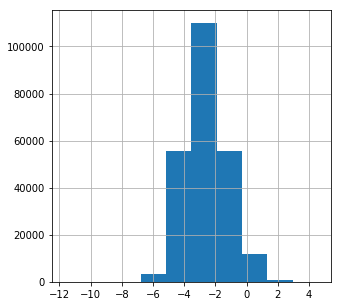

In [29]:
#Distribution of log ratio score
fig = plt.figure(figsize = (5,5))
ax = fig.gca()
df.log_ratio.hist(ax=ax)
plt.show()

In [30]:
df.d_log_ratio.unique()

array([ -3,  -2,  -4,  -5,  -1,  -6,   0,   1,   2,   3,   4,  -7, -10,
        -9, -11])

In [31]:
df['d_log_ratio_target']=df.d_log_ratio.apply(lambda x: 0 if x<=0 else x)

In [32]:
df.d_log_ratio_target.unique()

array([0, 1, 2, 3, 4])

In [33]:
df.d_log_ratio_target.value_counts()

0    235152
1      1591
2       174
3        14
4         2
Name: d_log_ratio_target, dtype: int64

In [34]:
df['d_log_ratio_target2']=df.d_log_ratio_target.apply(lambda x: 1 if x>0 else 0)

In [35]:
df['d_log_ratio_target2'].value_counts()

0    235152
1      1781
Name: d_log_ratio_target2, dtype: int64

In [36]:
1781/235152

0.007573824590052391

In [37]:
df.ratio_target.unique()

array([0, 1])

In [38]:
# 0    246867
# 1      2849
# 0    235561
# 1      1372
df.ratio_target.value_counts()

0    235561
1      1372
Name: ratio_target, dtype: int64

In [39]:
1372/235561

0.005824393681466796

### Word Coud

* Let's see what the cleaned text looks like:

In [40]:
!pip install wordcloud

You should consider upgrading via the 'pip install --upgrade pip' command.


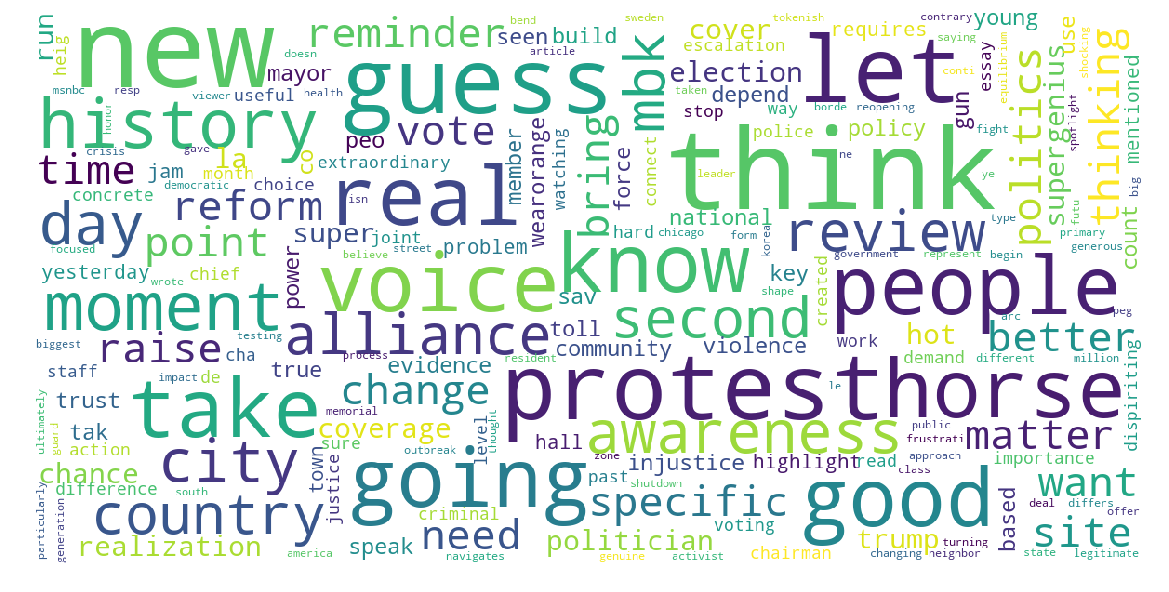

In [41]:
# wordcloud function

from wordcloud import WordCloud

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color = 'white',
        max_words = 200,
        max_font_size = 40, 
        scale = 3,
        random_state = 42
    ).generate(str(data))

    fig = plt.figure(1, figsize = (20, 20))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize = 20)
        fig.subplots_adjust(top = 2.3)

    plt.imshow(wordcloud)
    plt.show()
    
# print wordcloud
show_wordcloud(df['cleaned_text'])

* Let's also look at the word clouds for ratio vs. non-ratio

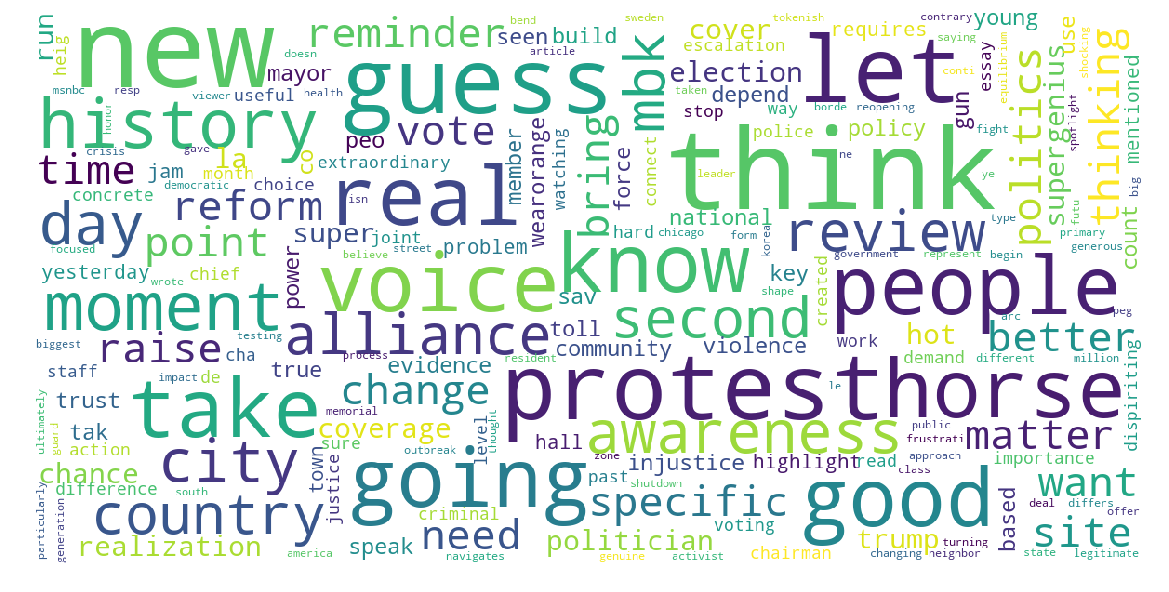

In [42]:
# Non-ratio word cloud
show_wordcloud(df[df.ratio_target==0]['cleaned_text'])

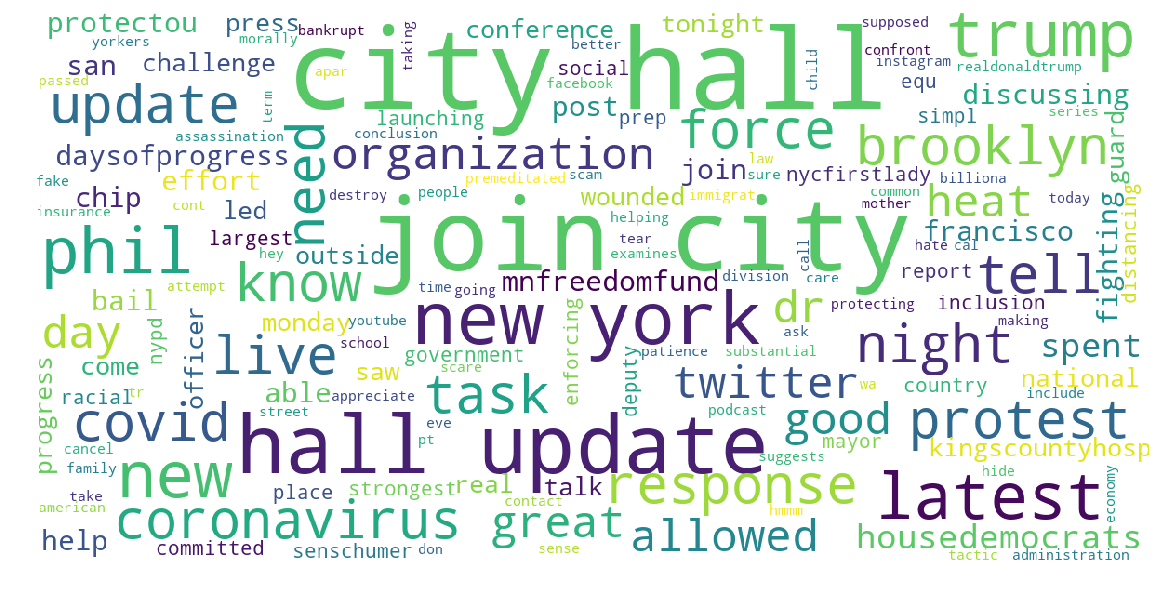

In [43]:
# Ratio word cloud
show_wordcloud(df[df.ratio_target==1]['cleaned_text'])

### Underdampling Strategy

* Since ratios represent only a small portion of our data, let's undersample the majority (non-ratio class) so that we have a balanced dataset.

In [44]:
!pip install imblearn

You should consider upgrading via the 'pip install --upgrade pip' command.


In [45]:
import imblearn
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split

In [46]:
# define undersample strategy & drop target column from features
undersample = RandomUnderSampler(sampling_strategy='majority')

features_under, labels_under = undersample.fit_resample(df.drop(columns='ratio_target'), df['ratio_target'])

X_train, X_validate, y_train, y_validate= train_test_split(features_under, labels_under, stratify=labels_under, random_state=42, test_size=0.1)

In [47]:
X_train.shape, X_validate.shape

((2469, 54), (275, 54))

In [48]:
X_train.head()

,account_id,author_id,category,cleaned_text,cluster_labels,created_at,d_log_ratio,d_richter_like_ratio,d_richter_retweet_ratio,date,...,tweet_id,url,url_attached,url_present,username,verified,year,date_num,d_log_ratio_target,d_log_ratio_target2
2400,19726613,19726613,1,goal people maine safe healthy possible time p...,1,Thu Jan 29 18:56:59 +0000 2009,1,3.0,7.0,2020-03-13 17:30:28+00:00,...,1238517800626511878,http://t.co/GC3gCGTqQX,https://www.collins.senate.gov/newsroom/senato...,1,senatorcollins,1,2020,438,1,1
1972,457984599,457984599,2,coming want pelosi said u s s commitment tackl...,1,Sun Jan 08 01:50:52 +0000 2012,1,3.0,5.0,2019-12-02 18:57:54+00:00,...,1201576241373032448,http://t.co/2sVbt3n6lO,https://trib.al/CgSU4LV,1,breitbartnews,1,2019,336,1,1
2058,457984599,457984599,2,trump white house national security adviser h ...,1,Sun Jan 08 01:50:52 +0000 2012,1,5.0,7.0,2019-10-10 21:43:40+00:00,...,1182411400691539968,http://t.co/2sVbt3n6lO,https://trib.al/aJ6oCwn,1,breitbartnews,1,2019,283,1,1
2350,65493023,65493023,1,beto o rourke interview reveals lack substance...,1,Thu Aug 13 22:56:16 +0000 2009,1,5.0,7.0,2019-01-16 06:27:06+00:00,...,1085423179953332224,https://t.co/H1wcJknrol,https://www.chicksonright.com/youngconservativ...,1,sarahpalinusa,1,2019,16,1,1
15,14412533,14412533,2,edlavacnn favorite reporter cnn,1,Wed Apr 16 20:34:24 +0000 2008,0,0.0,0.0,2019-07-19 14:34:39+00:00,...,1152225242003202048,https://t.co/VM2JQsQH6X,None,0,cillizzacnn,1,2019,200,0,0


* Be mindful, the original sample indices have been rearanged. But now we have an even number of ratios in our training and validation sets, and ratios make up ~50% of each data set:

In [49]:
#Cleaned text, following sampling
features_under.cleaned_text.loc[1650]

'president trump took dancing competition seriously tweeting support seanspicer urging maga universe cast vote man remained loyal perilous time president dance party end eventually'

In [50]:
#From original dataframe, original text
df.text.loc[1650]

'Looking forward to joining you all to celebrate in a few short months, @smithcollege! #Smith2020'

In [51]:
#Ratios make up 50% of dataset
y_train.mean(), y_validate.mean()

(0.5002025111381126, 0.49818181818181817)

In [52]:
#Total number of ratios in training/validation sets
y_train.sum(), y_validate.sum()

(1235, 137)

In [53]:
word_lists=X_train['cleaned_text'].apply(lambda x: x.split())
word_lists2=X_validate['cleaned_text'].apply(lambda x: x.split())
word_lists[:5]

2400    [goal, people, maine, safe, healthy, possible,...
1972    [coming, want, pelosi, said, u, s, s, commitme...
2058    [trump, white, house, national, security, advi...
2350    [beto, o, rourke, interview, reveals, lack, su...
15                   [edlavacnn, favorite, reporter, cnn]
Name: cleaned_text, dtype: object

In [54]:
word_len=X_train['cleaned_text'].apply(lambda x: len(x.split()))
word_len[:5]

2400    26
1972    13
2058    20
2350    24
15       4
Name: cleaned_text, dtype: int64

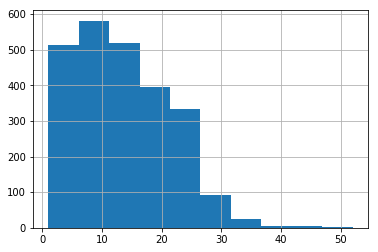

In [55]:
#Check distribution of # of words in training set
word_len.hist()

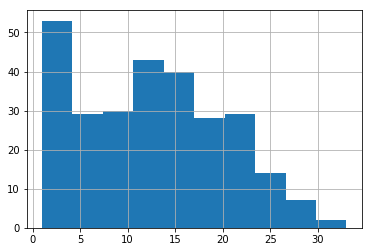

In [56]:
#Check distribution of # of words in validation set
word_len2=X_validate['cleaned_text'].apply(lambda x: len(x.split()))
word_len2[:5]
word_len2.hist()

Let's use 49 words as our cutoff, since it is the maximum length of our training set, and the distribution of # of words is similar in our validation set:

In [57]:
maxLen =word_len.max()
maxLen

52

#### One-hot encoding
* Let's one-hot encode our target value (y-->y_oh). We only have ratio and non-ratio targets, so # of columns (c) =2

In [58]:
def convert_to_one_hot(y, c):
    y = np.eye(c)[np.array(y).reshape(-1)] #pd.DataFrame(np.eye(c)[np.array(y).reshape(-1)], index=y.index)
    return y

In [59]:
y_oh_train = convert_to_one_hot(y_train, c = 2)
y_oh_validate = convert_to_one_hot(y_validate, c = 2)

In [60]:
y_train[:3]

2400    1
1972    1
2058    1
Name: ratio_target, dtype: int64

In [61]:
y_oh_train [:3]

array([[0., 1.],
       [0., 1.],
       [0., 1.]])

### GloVe Word Embedding

(Implementation of this model was largely based on protocol followed from Deep Learning AI's Sequence Models course: https://www.coursera.org/learn/nlp-sequence-models/) 

* Use pre-trained 200-dimensional GloVe embeddings to convert each word in the input sentence into their word vector representations. (2B tweets, 27B tokens, 1.2M vocab, uncased, 200d vectors; download: https://nlp.stanford.edu/projects/glove/)
* Then take an average of the word vectors. 

In [62]:
def read_glove_vecs(glove_file):
    with open(glove_file, 'r') as f:
        words = set()
        word_to_vec_map = {}
        for line in f:
            line = line.strip().split()
            curr_word = line[0]
            words.add(curr_word)
            word_to_vec_map[curr_word] = np.array(line[1:], dtype=np.float64)
        
        i = 1
        words_to_index = {}
        index_to_words = {}
        for w in sorted(words):
            words_to_index[w] = i
            index_to_words[i] = w
            i = i + 1
    return words_to_index, index_to_words, word_to_vec_map

In [63]:
word_to_index, index_to_word, word_to_vec_map = read_glove_vecs('glove.twitter.27B.200d.txt')

In [64]:
len(word_to_index), len(index_to_word), len(word_to_vec_map)

(394390, 394390, 394390)

In [65]:
#Word index, given word
word_to_index['hello']

97990

In [66]:
#Word, given index
index_to_word[254761]

'ξn'

In [67]:
#100d vector, given word
word_to_vec_map['hello']

array([ 3.4683e-01, -1.9612e-01, -3.4923e-01, -2.8158e-01, -7.5627e-01,
       -4.0035e-02,  5.3422e-01,  1.5327e-03, -2.1963e-01, -5.6708e-01,
       -7.5112e-02,  3.9074e-01,  1.9201e-01,  4.8046e-02, -1.6801e-01,
       -1.9140e-01,  1.2162e-01, -2.2513e-01,  2.2276e-02, -2.7632e-01,
        1.0721e-01, -5.8191e-02, -1.7654e-01, -2.0620e-02, -3.9768e-02,
        1.2619e-01,  1.8927e-01,  1.7017e-01, -2.3453e-02, -4.2349e-01,
       -4.2640e-02, -2.8101e-01, -3.2461e-01,  3.0870e-01,  9.4529e-02,
        1.3559e-01, -5.0249e-01,  3.0072e-01,  1.5805e-01,  5.5079e-01,
       -3.7005e-01, -2.1721e-01, -7.1162e-01,  4.2975e-01, -1.2451e-02,
       -2.4275e-01, -6.2902e-02,  4.3755e-02,  5.9098e-02,  2.1553e-01,
        3.4048e-02, -1.5735e-01, -4.4731e-02, -1.2719e-01,  3.3347e-01,
        2.2386e-01,  3.9716e-01,  8.4382e-02, -4.7057e-02, -1.4943e-01,
        2.0140e-02, -5.1345e-02, -1.7782e-02, -4.8558e-01, -4.4077e-02,
        3.8690e-01, -3.5139e-01,  8.8997e-01,  6.6970e-01, -4.40

- `word_to_index`: dictionary mapping from words to their indices in the vocabulary 
- `index_to_word`: dictionary mapping from indices to their corresponding words in the vocabulary
- `word_to_vec_map`: dictionary mapping words to their GloVe vector representation.

Strategy:
* Convert every sentence to lower-case, then split the sentence into a list of words. 
* For each word in the sentence, access its GloVe representation.
* Get average of word vectors.

In [68]:
#Function to take average of sentence word vectors
def sentence_to_avg(sentence, word_to_vec_map, vector_len=200):
    #Split sentence into list of lower case words (≈ 1 line)
    words = sentence.lower().split()
    # Initialize the average word vector, should have the same shape as your word vectors.
    avg = np.zeros(vector_len,)
    #average the word vectors. You can loop over the words in the list "words".
    total = 0
           
    for w in words:
        if w in word_to_vec_map:
            total += word_to_vec_map[w]
        else: #handles case when word is not in GloVe dictionary
            total += np.zeros(vector_len,)
    if len(words)>0: #If words present
        avg = total/len(words)
    return avg

In [69]:
avg = sentence_to_avg("I love ice cream", word_to_vec_map)
print("avg = \n", avg)

avg = 
 [-3.23681500e-01 -2.89587250e-01 -6.98617500e-02  4.58987500e-02
 -1.05257500e-01  1.05640500e-01  2.70840000e-01 -2.20704250e-01
 -1.47629175e-01 -6.96320000e-01 -1.40917500e-01 -2.84432500e-01
 -7.56262500e-01  4.72842500e-02 -5.17866500e-01  9.40897500e-02
  2.86605000e-01 -3.44127000e-01 -9.07350000e-02  1.05800950e-01
 -1.55551000e-01  8.82245000e-02  2.14479025e-01 -3.34815500e-02
 -1.57322500e-02  6.77547500e-01 -2.31225000e-01  3.47192250e-01
 -2.56800000e-02 -1.91217500e-01 -3.05742250e-01 -5.01955000e-02
 -4.65935000e-01 -1.75715000e-01 -1.57970500e-01  2.51875000e-02
  5.17887500e-02  1.05307500e-01  1.61779500e-01  5.48847500e-01
 -3.12229000e-01 -3.36546000e-01 -9.38300000e-02 -3.89004750e-01
  3.51987500e-01  4.76170000e-02  2.23674250e-01  1.90037500e-01
  4.71447500e-02 -4.09736750e-01  3.24040750e-02 -1.98107950e-01
 -2.96074250e-01  1.72355000e-01  1.68632500e-01 -1.63310000e-01
  3.55025000e-01  4.30322500e-02 -9.56942500e-02  6.88802500e-02
 -4.45260000e-01 

(Adapted from Sequence Models course):

#### Model

Strategy:
* Pass the average through forward propagation
* Compute the cost
* Backpropagate to update the softmax parameters

In [70]:
def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()

In [71]:
def predict(X, Y, W, b, word_to_vec_map, vector_len=200):
    """
    Given X (sentences) and Y (target ratio), predict if ratioed and compute the accuracy of the model over the given set.
    
    Arguments:
    X -- input data containing sentences, numpy array of shape (m, None)
    Y -- labels, containing index of the ratio/non-ratio, numpy array of shape (m, 1)
    
    Returns:
    pred -- numpy array of shape (m, 1) with your predictions
    """
    m = X.shape[0]
    pred = np.zeros((m, 1))
    
    for j in range(m):                       # Loop over training examples
        
        # Split jth test example (sentence) into list of lower case words
        words = X[j].lower().split()
        
        # Average words' vectors
        avg = np.zeros((vector_len,))
        for w in words:
            if w in word_to_vec_map:
                avg += word_to_vec_map[w]
            else:
                avg += np.zeros(vector_len,)
        if len(words)>0:
            avg = avg/len(words)

        # Forward propagation
        Z = np.dot(W, avg) + b
        A = softmax(Z)
        pred[j] = np.argmax(A)
        
    print("Accuracy: "  + str(np.mean((pred[:] == Y.reshape(Y.shape[0],1)[:]))))
    
    return pred

In [72]:
def model(X, Y, word_to_vec_map, learning_rate = 0.01, num_iterations = 400, vector_len=200):
    """
    Model to train word vector representations in numpy.
    """
    np.random.seed(1)
    # Define number of training examples
    m = Y.shape[0]                          # number of training examples
    #x_idx=list(X.index)
    n_y = 2                                 # number of classes  
    n_h = vector_len                                # dimensions of the GloVe vectors  
    # Initialize parameters using Xavier initialization
    W = np.random.randn(n_y, n_h) / np.sqrt(n_h)
    b = np.zeros((n_y,))
    # Convert Y to Y_onehot with n_y classes
    Y_oh = convert_to_one_hot(Y, c = n_y) 
    # Optimization loop
    for t in range(num_iterations): # Loop over the number of iterations
        for i in range(m): # Loop over the training examples
            # Average the word vectors of the words from the i'th training example
            avg = sentence_to_avg(X[i], word_to_vec_map)
            # Forward propagate the avg through the softmax layer
            z = np.dot(W,avg) +b
            a = softmax(z)
            # Compute cost using the i'th training label's one hot representation and "A" (the output of the softmax)
            cost = -np.sum(Y_oh[i]*np.log(a))
            # Compute gradients 
            dz = a - Y_oh[i]
            dW = np.dot(dz.reshape(n_y,1), avg.reshape(1, n_h))
            db = dz
            # Update parameters with Stochastic Gradient Descent
            W = W - learning_rate * dW
            b = b - learning_rate * db
        if t % 100 == 0:
            print("Epoch: " + str(t) + " --- cost = " + str(cost))
            pred = predict(X, Y, W, b, word_to_vec_map) #predict is defined in emo_utils.py
    return pred, W, b

Run the next cell to train your model and learn the softmax parameters (W,b). 

In [73]:
#list(X_train.index)

In [74]:
pred, W, b = model(np.array(X_train.cleaned_text), np.array(y_train), word_to_vec_map)
print(pred)

Epoch: 0 --- cost = 0.394030461976609
Accuracy: 0.6978533819360064
Epoch: 100 --- cost = 0.5478448399956252
Accuracy: 0.7383556095585257
Epoch: 200 --- cost = 0.5672281529496047
Accuracy: 0.7371405427298502
Epoch: 300 --- cost = 0.5733834519946357
Accuracy: 0.7371405427298502
[[1.]
 [1.]
 [1.]
 ...
 [0.]
 [1.]
 [0.]]


### Evaluating validation set performance



In [75]:
print("Training set:")
pred_train = predict(np.array(X_train.cleaned_text), np.array(y_train), W, b, word_to_vec_map)
print('Test set:')
pred_test = predict(np.array(X_validate.cleaned_text), np.array(y_validate), W, b, word_to_vec_map)

Training set:
Accuracy: 0.7379505872823006
Test set:
Accuracy: 0.6618181818181819


#### Word ordering isn't considered in this model
* This algorithm ignores word ordering
* It doesn't understand combinations of words.
* It just averages all the words' embedding vectors together, without considering the ordering of words. 

#### Confusion matrix
* Printing the confusion matrix can also help understand which classes are more difficult for your model. 
* A confusion matrix shows how often an example whose label is one class ("actual" class) is mislabeled by the algorithm with a different class ("predicted" class).

In [76]:
def plot_confusion_matrix(y_actu, y_pred, title='Confusion matrix', cmap=plt.cm.gray_r):
    
    df_confusion = pd.crosstab(y_actu, y_pred.reshape(y_pred.shape[0],), rownames=['Actual'], colnames=['Predicted'], margins=True)
    
    df_conf_norm = df_confusion / df_confusion.sum(axis=1)
    
    plt.matshow(df_confusion, cmap=cmap) # imshow
    #plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(df_confusion.columns))
    plt.xticks(tick_marks, df_confusion.columns, rotation=45)
    plt.yticks(tick_marks, df_confusion.index)
    #plt.tight_layout()
    plt.ylabel(df_confusion.index.name)
    plt.xlabel(df_confusion.columns.name)

(275,)
             0    1
Predicted  0.0  1.0  All
Actual                  
0           81   57  138
1           36  101  137
All        117  158  275


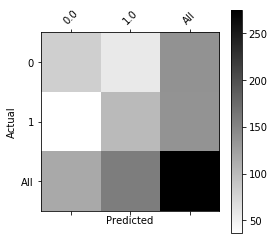

In [77]:
print(y_validate.shape)
print('             '+ '0'+ '    ' + '1')
print(pd.crosstab(y_validate, pred_test.reshape(X_validate.shape[0],), rownames=['Actual'], colnames=['Predicted'], margins=True))
plot_confusion_matrix(y_validate, pred_test)

## Using LSTMs in Keras: 

Let's build an LSTM model that takes word **sequences** as input!
* This model will be able to account for the word ordering. 
* We will continue to use pre-trained word embeddings to represent words.
* We will feed word embeddings into an LSTM.
* The LSTM will learn to predict ratio/non-ratio. 


In [78]:
import numpy as np
np.random.seed(0)
from keras.models import Model
from keras.layers import Dense, Input, Dropout, LSTM, Activation
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.initializers import glorot_uniform
np.random.seed(1)

Using TensorFlow backend.


In [80]:


def sentences_to_indices(X, word_to_index, max_len):
    """
    Converts an array of sentences (strings) into an array of indices corresponding to words in the sentences.
    The output shape should be such that it can be given to `Embedding()` (described in Figure 4). 
    
    Arguments:
    X -- array of sentences (strings), of shape (m, 1)
    word_to_index -- a dictionary containing the each word mapped to its index
    max_len -- maximum number of words in a sentence. You can assume every sentence in X is no longer than this. 
    
    Returns:
    X_indices -- array of indices corresponding to words in the sentences from X, of shape (m, max_len)
    """
    
    m = X.shape[0]                                   # number of training examples
    
  
    # Initialize X_indices as a numpy matrix of zeros and the correct shape (≈ 1 line)
    X_indices = np.zeros((m, max_len))
    
    for i in range(m):                               # loop over training examples
        
        # Convert the ith training sentence in lower case and split is into words. You should get a list of words.
        sentence_words =X[i].lower().split()[:max_len] #Limit words to maxLen in training data
        
        # Initialize j to 0
        j = 0
        
        # Loop over the words of sentence_words
        for w in sentence_words:
            # Set the (i,j)th entry of X_indices to the index of the correct word.
            if w in word_to_index:
                X_indices[i, j] = word_to_index[w]
            else:
                #If word not present as embedding, add it as a slash
                X_indices[i, j] = word_to_index['/']
            # Increment j to j + 1
            j +=1
            
    return X_indices

In [82]:


def pretrained_embedding_layer(word_to_vec_map, word_to_index, vector_len=200):
    """
    Creates a Keras Embedding() layer and loads in pre-trained GloVe 50-dimensional vectors.
    
    Arguments:
    word_to_vec_map -- dictionary mapping words to their GloVe vector representation.
    word_to_index -- dictionary mapping from words to their indices in the vocabulary (400,001 words)

    Returns:
    embedding_layer -- pretrained layer Keras instance
    """
    
    vocab_len = len(word_to_index) + 1                  # adding 1 to fit Keras embedding (requirement)
    emb_dim = word_to_vec_map["cucumber"].shape[0]      # define dimensionality of your GloVe word vectors (= 50-200)
    
    # Step 1
    # Initialize the embedding matrix as a numpy array of zeros.
  
    emb_matrix = np.zeros((vocab_len, emb_dim))
    
    # Step 2
    # Set each row "idx" of the embedding matrix to be 
    # the word vector representation of the idx'th word of the vocabulary
    for word, idx in word_to_index.items():
        if len(word_to_vec_map[word])==vector_len:
            emb_matrix[idx, :] = word_to_vec_map[word]
        else:
            #If length of vector is less than vector length, append zeros to make equal to required vector length
            emb_matrix[idx, :] = np.append(word_to_vec_map[word],np.zeros(vector_len-len(word_to_vec_map[word])))

    # Step 3
    # Define Keras embedding layer with the correct input and output sizes
    # Make it non-trainable.
    embedding_layer = Embedding(vocab_len, emb_dim, trainable = False)

    # Step 4 
    # Build the embedding layer, it is required before setting the weights of the embedding layer. 
    embedding_layer.build((None,)) # Do not modify the "None".  This line of code is complete as-is.
    
    # Set the weights of the embedding layer to the embedding matrix. Your layer is now pretrained.
    embedding_layer.set_weights([emb_matrix])
    
    return embedding_layer

In [83]:
embedding_layer = pretrained_embedding_layer(word_to_vec_map, word_to_index)
print("weights[0][1][3] =", embedding_layer.get_weights()[0][1][3])










weights[0][1][3] = -0.31723


In [84]:
embedding_layer.__dict__

{'input_spec': None,
 'supports_masking': False,
 'stateful': False,
 '_trainable_weights': [<tf.Variable 'embeddings:0' shape=(394391, 200) dtype=float32_ref>],
 '_non_trainable_weights': [],
 '_losses': [],
 '_updates': [],
 '_per_input_losses': {},
 '_per_input_updates': {},
 '_built': True,
 '_inbound_nodes': [],
 '_outbound_nodes': [],
 'name': 'embedding_1',
 'trainable': False,
 'batch_input_shape': (None, None),
 'dtype': 'float32',
 '_initial_weights': None,
 'input_dim': 394391,
 'output_dim': 200,
 'embeddings_initializer': <keras.initializers.RandomUniform at 0x7f6482735ef0>,
 'embeddings_regularizer': None,
 'activity_regularizer': None,
 'embeddings_constraint': None,
 'mask_zero': False,
 'input_length': None,
 'embeddings': <tf.Variable 'embeddings:0' shape=(394391, 200) dtype=float32_ref>}

## 2.3 Building LSTM Model
 
* Embedding layer output is fed to an LSTM network. 

* The model takes as input an array of sentences of shape (`m`, `max_len`, ) defined by `input_shape`. 
* The model outputs a softmax probability vector of shape (`m`, `c = 2`). 

* Basedvon the following Keras layers:
    * [Input()](https://keras.io/layers/core/#input)
        * Set the `shape` and `dtype` parameters.
        * The inputs are integers, so you can specify the data type as a string, 'int32'.
    * [LSTM()](https://keras.io/layers/recurrent/#lstm)
        * Set the `units` and `return_sequences` parameters.
    * [Dropout()](https://keras.io/layers/core/#dropout)
        * Set the `rate` parameter.
    * [Dense()](https://keras.io/layers/core/#dense)
        * Set the `units`, 
        * Note that `Dense()` has an `activation` parameter.  For the purposes of passing the autograder, please do not set the activation within `Dense()`.  Use the separate `Activation` layer to do so.
    * [Activation()](https://keras.io/activations/).
        * You can pass in the activation of your choice as a lowercase string.
    * [Model](https://keras.io/models/model/)
        Set `inputs` and `outputs`.

In [85]:

def keras_model(input_shape, word_to_vec_map, word_to_index):
    """
    Function creating keras model's graph.
    
    Arguments:
    input_shape -- shape of the input, usually (max_len,)
    word_to_vec_map -- dictionary mapping every word in a vocabulary into its 100 dimensional vector representation
    word_to_index -- dictionary mapping from words to their indices in the vocabulary 

    Returns:
    model -- a model instance in Keras
    """
    
    # Define sentence_indices as the input of the graph.
    # It should be of shape input_shape and dtype 'int32' (as it contains indices, which are integers).
    sentence_indices = Input(shape=(input_shape), dtype='int32')
    
    # Create the embedding layer pretrained with GloVe Vectors (≈1 line)
    embedding_layer = pretrained_embedding_layer(word_to_vec_map, word_to_index)
    
    # Propagate sentence_indices through your embedding layer
    # (See additional hints in the instructions).
    embeddings = embedding_layer(sentence_indices)     
    
    # Propagate the embeddings through an LSTM layer with 128-dimensional hidden state
    # The returned output should be a batch of sequences.
    X = LSTM(units = 128, return_sequences= True)(embeddings)
    # Add dropout with a probability of 0.5
    X = Dropout(rate = 0.5 )(X)
    # Propagate X trough another LSTM layer with 128-dimensional hidden state
    # The returned output should be a single hidden state, not a batch of sequences.
    X = LSTM(units=128, return_sequences=False)(X)
    
    # Add dropout with a probability of 0.5
    X = Dropout(rate = 0.5 )(X)
    # Propagate X through a Dense layer with 5 units
    X = Dense(units =2)(X)
    # Add a softmax activation
    X = Activation('softmax')(X)
    
    # Create Model instance which converts sentence_indices into X.
    model = Model(inputs=sentence_indices, outputs=X)
    
    return model

In [86]:
maxLen

52

In [87]:
model = keras_model((maxLen,), word_to_vec_map, word_to_index)
model.summary()


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 52)                0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 52, 200)           78878200  
_________________________________________________________________
lstm_1 (LSTM)                (None, 52, 128)           168448    
_________________________________________________________________
dropout_1 (Dropout)          (None, 52, 128)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
__________________________

* Compile model using `categorical_crossentropy` loss, `adam` optimizer and `['accuracy']` metrics:

In [88]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

* Train model. Takes as input an array of shape (`m`, `max_len`) and outputs probability vectors of shape (`m`, `number of classes`). 
* Converts X_train (array of sentences as strings) to X_train_indices (array of sentences as list of word indices), and Y_train (labels as indices) to Y_train_oh (labels as one-hot encoded vectors).

In [89]:
X_train_indices = sentences_to_indices(np.array(X_train.cleaned_text), word_to_index, maxLen)
Y_train_oh = convert_to_one_hot(np.array(y_train), c = 2)

Fit the Keras model on `X_train_indices` and `Y_train_oh`. We will use `epochs = 30` and `batch_size = 32`.

In [90]:
model.fit(X_train_indices, Y_train_oh, epochs = 30, batch_size=32, shuffle=True)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/30
2469/2469 [==============================] - 40s 16ms/step - loss: 0.6687 - acc: 0.5877
Epoch 2/30
2469/2469 [==============================] - 36s 15ms/step - loss: 0.6150 - acc: 0.6521
Epoch 3/30
2469/2469 [==============================] - 35s 14ms/step - loss: 0.5997 - acc: 0.6873
Epoch 4/30
2469/2469 [==============================] - 35s 14ms/step - loss: 0.7117 - acc: 0.5520
Epoch 5/30
2469/2469 [==============================] - 35s 14ms/step - loss: 0.6995 - acc: 0.5496
Epoch 6/30
2469/2469 [==============================] - 35s 14ms/step - loss: 0.6419 - acc: 0.6428
Epoch 7/30
2469/2469 [==============================] - 36s 15ms/step - loss: 0.6368 - acc: 0.6497
Epoch 8/30
2469/2469 [==============================] - 36s 15ms/step - loss: 0.6002 - acc: 0.6938
Epoch 9/30
2469/2469 [==============================] - 36s 15ms/step - loss: 0.5781 - acc: 0.7132
Epoch 10/30
2

In [91]:
model.save('glove_keras_200d_v2')

In [93]:
from tensorflow import keras
model2 = keras.models.load_model('glove_keras_200d_v2')

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [94]:
X_test_indices = sentences_to_indices(np.array(X_validate.cleaned_text), word_to_index, maxLen)
Y_test_oh = convert_to_one_hot(np.array(y_validate), c = 2)
loss, acc = model2.evaluate(X_test_indices, Y_test_oh)

print()
print("Test accuracy = ", acc)

275/275 [==============================] - 1s 5ms/sample - loss: 0.7927 - acc: 0.6873

Test accuracy =  0.6872727


Let's see the tweets that were mislabelled by the GloVE-LSTM model:

In [95]:
# See mislabelled tweets in validation set
c = 2
y_test_oh = np.eye(c)[np.array(y_validate).reshape(-1)]
X_test_indices = sentences_to_indices(np.array(X_validate.cleaned_text), word_to_index, maxLen)
pred = model2.predict(X_test_indices)
j=0
for i in range(len(np.array(X_validate.cleaned_text))):
    x = X_test_indices
    predict_num= np.argmax(pred[i])
    if(predict_num != np.array(y_validate)[i]):
        j+=1
        #X_n=
        #y_n=
        print(j, 'Actual label:',list(y_validate)[i],'; Prediction:',predict_num,'Probability (%):',round(pred[i][1]*100,2),': Text:', list(X_validate.cleaned_text)[i])

1 Actual label: 1 ; Prediction: 0 Probability (%): 6.5 : Text: dedicated service defense nation commended blessed soldier like leading example selfless commitment nation
2 Actual label: 0 ; Prediction: 1 Probability (%): 81.81 : Text: trump told governor buy virus supply outbid
3 Actual label: 0 ; Prediction: 1 Probability (%): 70.89 : Text: believe article story read us anonymous source having trade subject accept information actual living fake news medium make source story believe
4 Actual label: 1 ; Prediction: 0 Probability (%): 6.49 : Text: ain t happy
5 Actual label: 1 ; Prediction: 0 Probability (%): 6.49 : Text: raid f kers
6 Actual label: 0 ; Prediction: 1 Probability (%): 50.94 : Text: mueller s labored performance departure fabled stamen new york time feel sorry mueller feel worse victim incompetence gang mockery right citizen great nation
7 Actual label: 1 ; Prediction: 0 Probability (%): 6.52 : Text: system work
8 Actual label: 1 ; Prediction: 0 Probability (%): 6.49 : Tex

Check to see if we can load the saved model

In [96]:
loss, acc = model2.evaluate(X_test_indices, Y_test_oh)
loss, acc

275/275 [==============================] - 1s 3ms/sample - loss: 0.7927 - acc: 0.6873


(0.7926755831458352, 0.6872727)

## Notes
* LSTM version accounts for word order
* Keras' outputs are slightly random each time, so do not always obtain the same result.
* Model would most-likely perform better with a larger dataset of ratios
